In [ ]:
conda install tensorflow

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from scipy import stats


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
   
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
     
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    rhand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    lhand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, rhand, lhand])

In [6]:
#MAKE INITIAL DIRECTORY
DATA_PATH = os.path.join('D:/DataSet/MP_Data_US/') 
#D:/DataSet/Codes/MP_Data/
#D:/DataSet/MP_Data_US/
subdirectories_file_path = 'D:/DataSet/Codes/Labels_US.txt'
#D:/DataSet/Codes/Labels.txt
#
with open(subdirectories_file_path, 'r') as file:
    actions = np.array([line.strip() for line in file.readlines()])
    
#'D:/DataSet/Codes/gloss.txt'
no_sequences = 30

sequence_length = 30

start_folder = 1

In [7]:
len(actions)

11

In [7]:
#cvtest
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
#feels like this is stuck! DEBUG LATER!
VIDEO_DATA_PATH = 'D:/DataSet/SignBD-Word/SignBD-Word_RGB/DATASET/'
OUTPUT_NPY_PATH = 'D:/DataSet/Codes/MP_Data/'

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder + no_sequences):
            # Create subdirectory for each video
            output_subdirectory = os.path.join(OUTPUT_NPY_PATH, action, str(sequence))
            os.makedirs(output_subdirectory, exist_ok=True)

            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read video frame
                video_path = os.path.join(VIDEO_DATA_PATH, action, f"{sequence}.mp4")
                cap = cv2.VideoCapture(video_path)

                # Check if the video file is opened successfully
                if not cap.isOpened():
                    print(f"Error: Could not open video file {video_path}")
                    break

                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Display image
                cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(output_subdirectory, f"keypoints_{action}_{sequence}_{frame_num}.npy")
                np.save(npy_path, keypoints)

                # Break after finish
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

                # Release video capture object
                cap.release()

    cv2.destroyAllWindows()

In [8]:
VIDEO_DATA_PATH = 'D:/DataSet/Dataset_US/'
#D:/DataSet/Dataset_US/
#D:/DataSet/SignBD-Word/SignBD-Word_RGB/DATASET/
OUTPUT_NPY_PATH = 'D:/DataSet/MP_Data_US/'
#D:/DataSet/MP_Data_US/
#D:/DataSet/Codes/MP_Data/

In [9]:
#Use for Pre-recorded Dataset
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through actions array
    for action in actions:
        # Loop through sequences or videos
        for sequence in range(start_folder, start_folder + no_sequences):
            # Create subdirectory for each video
            output_subdirectory = os.path.join(OUTPUT_NPY_PATH, action, str(sequence))
            os.makedirs(output_subdirectory, exist_ok=True)

            # Read video frame outside the frame_num loop
            video_path = os.path.join(VIDEO_DATA_PATH, action, f"{sequence}.mp4")
            cap = cv2.VideoCapture(video_path)

            # Check if the video file is opened successfully
            if not cap.isOpened():
                print(f"Error: Could not open video file {video_path}")
                break

            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Display image
                cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                # Visualize keypoints on the image
                keypoints = extract_keypoints(results)
                for i in range(0, len(keypoints), 3):
                    x, y, _ = int(keypoints[i]), int(keypoints[i + 1]), int(keypoints[i + 2])
                    cv2.circle(image, (x, y), 5, (0, 255, 0), -1)

                # Display the image with keypoints
                cv2.imshow('OpenCV Feed with Keypoints', image)

                # Export keypoints
                npy_path = os.path.join(output_subdirectory, f"keypoints_{action}_{sequence}_{frame_num}.npy")
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            # Release video capture object
            cap.release()

    cv2.destroyAllWindows()


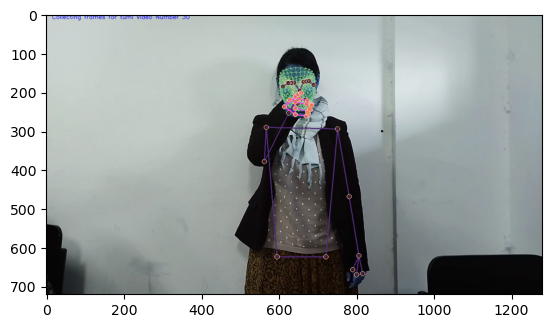

In [10]:
#HELLO hehehehe :)
plt.imshow(image)

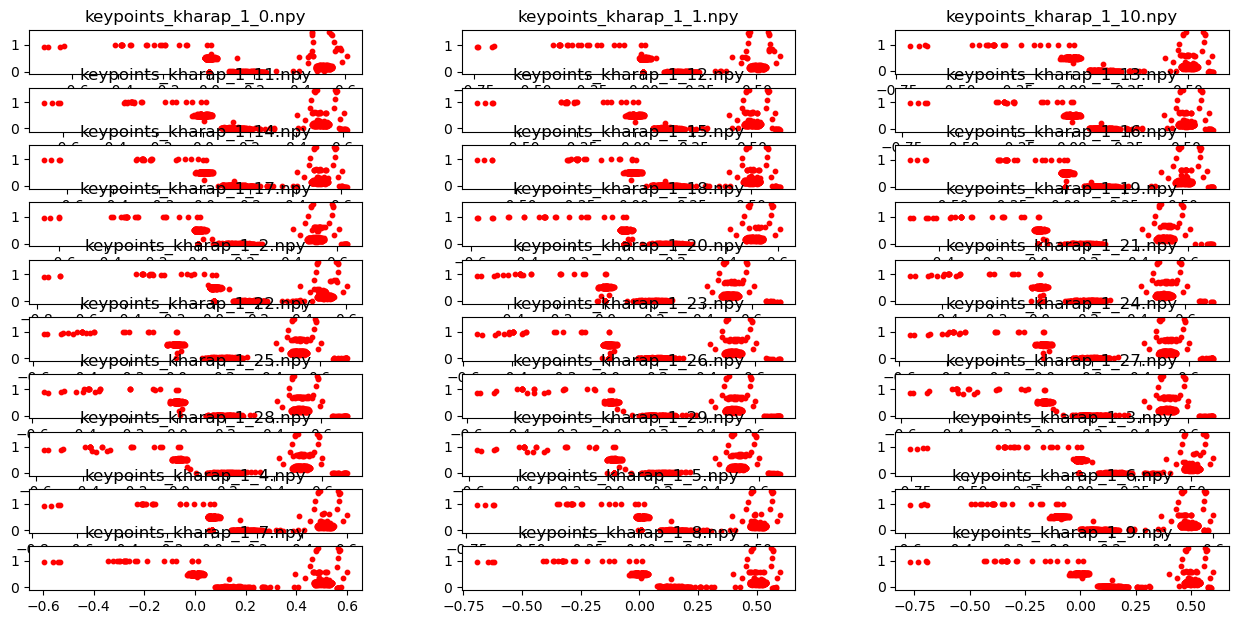

In [11]:
#KEYPOINTS TESTING
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the directory containing your .npy files
directory = 'D:/DataSet/MP_Data_US/kharap/1/'
#D:/DataSet/MP_Data_US/kharap/1/

# Get a list of all .npy files in the directory
npy_files = [file for file in os.listdir(directory) if file.endswith('.npy')]

# Determine the number of rows and columns for subplots
num_rows = int(np.ceil(len(npy_files) / 3))  # Adjust the number of columns as needed
num_cols = 3

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))  # Increase the height

# Loop through each .npy file and display the keypoints
for i, file in enumerate(npy_files):
    # Load the .npy file
    keypoints = np.load(os.path.join(directory, file))

    # Explicitly reshape the array to (n, 2) if needed
    keypoints = keypoints.reshape(-1, 2)

    # Choose the subplot position
    ax = axes[i // num_cols, i % num_cols]

    # Scatter plot for x and y coordinates of keypoints
    ax.scatter(keypoints[:, 0], keypoints[:, 1], s=10, c='red', marker='o')
    
    ax.set_title(file)  # Display the file name as the title

# Adjust layout manually
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

# Show the figure
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
Label_map = {label:num for num, label in enumerate(actions)}

In [14]:
len(Label_map)

11

In [15]:
sequences, labels = [], []

# Loop through actions
for action in actions:
    # Loop through sequences (videos)
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        # Initialize a window to store frames of the sequence
        window = []
        # Loop through frames of the sequence
        for frame_num in range(sequence_length):
            # Load keypoints from the corresponding .npy file
            npy_filename = f"keypoints_{action}_{sequence}_{frame_num}.npy"
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), npy_filename))
            window.append(res)
        # Append the window of frames to sequences
        sequences.append(window)
        # Append the numerical label to labels
        labels.append(Label_map[action])


In [16]:
#2220 videos, 30FPS each, each frame 1662 Holistic Keypoinmts
np.array(sequences).shape

(330, 30, 1662)

In [17]:
X = np.array(sequences)
X

array([[[ 0.5059672 ,  0.16579765, -0.41073662, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.50591481,  0.16582182, -0.40058693, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.50560546,  0.16605689, -0.35060173, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.50858825,  0.19978489, -0.38722938, ...,  0.51123518,
          0.70512342, -0.00817417],
        [ 0.50865281,  0.19941114, -0.39383593, ...,  0.5103243 ,
          0.70292562, -0.00494751],
        [ 0.5086652 ,  0.19923869, -0.39232156, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.53651804,  0.19756766, -0.33803472, ...,  0.6101132 ,
          0.59437615,  0.00234091],
        [ 0.53332937,  0.1797528 , -0.34252506, ...,  0.61095506,
          0.59117907,  0.00496174],
        [ 0.52937084,  0.17086972, -0.36976016, ...,  0.61019415,
          0.59206718,  0.00623831],
        ...,
        [ 0.53271675,  0.17681113, -0.32693279, ...,  

In [18]:
#CONVERT LABEL TO BIN FLAG
Y = to_categorical(labels).astype(int)

In [19]:
Y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [21]:
X_train.shape, Y_test.shape

((231, 30, 1662), (99, 11))

In [22]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
Y_train_reshaped = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test_reshaped = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import TensorBoard

In [24]:
log_dir = 'D:/DataSet/Codes/Logs/'
tb_callback = TensorBoard(log_dir=log_dir)

In [25]:
actions.shape[0], X.shape

(11, (330, 30, 1662))

In [26]:
#EXPERIMENT WITH MODEL
num_classes = actions.shape[0]

model = Sequential()
model.add(LSTM(512, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(Dropout(0.2))  # Add dropout to reduce overfitting
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [22]:
#Original Model
num_classes = actions.shape[0]
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [27]:
num_classes = actions.shape[0]

model = Sequential()
# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(30, 1662, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output before the dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

In [28]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
model.fit(X_train_reshaped, Y_train, epochs=70, callbacks=[tb_callback])

Epoch 1/70


8/8 [==============================] - 5s 444ms/step - loss: 2.6017 - categorical_accuracy: 0.1039
Epoch 2/70
8/8 [==============================] - 4s 438ms/step - loss: 2.3882 - categorical_accuracy: 0.1212
Epoch 3/70
8/8 [==============================] - 4s 433ms/step - loss: 2.2413 - categorical_accuracy: 0.2121
Epoch 4/70
8/8 [==============================] - 3s 430ms/step - loss: 1.9065 - categorical_accuracy: 0.3983
Epoch 5/70
8/8 [==============================] - 4s 440ms/step - loss: 1.6310 - categorical_accuracy: 0.4762
Epoch 6/70
8/8 [==============================] - 3s 432ms/step - loss: 1.2977 - categorical_accuracy: 0.5758
Epoch 7/70
8/8 [==============================] - 4s 437ms/step - loss: 1.0255 - categorical_accuracy: 0.6364
Epoch 8/70
8/8 [==============================] - 4s 435ms/step - loss: 0.8867 - categorical_accuracy: 0.7359
Epoch 9/70
8/8 [==============================] - 3s 432ms/step - loss: 0.7682 - categorical_accuracy: 0.7576
Epoch 10

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 1660, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 830, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 828, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 414, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 412, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 206, 128)      

In [43]:
res = model.predict(X_test_reshaped)
res[0]

4/4 [==============================] - 0s 58ms/step


array([1.2588703e-08, 2.0270514e-09, 9.3418724e-11, 4.1035539e-12,
       1.1452529e-12, 1.3579812e-09, 1.5892432e-09, 1.2203471e-14,
       1.3130158e-09, 1.0000000e+00, 4.6569009e-13], dtype=float32)

In [32]:
np.sum(res[0])

1.0

In [44]:
actions[np.argmax(res[5])]

'chamra'

In [45]:
actions[np.argmax(Y_test[5])]

'chamra'

In [98]:
del model

In [35]:
model.save('D:/DataSet/Codes/Checkpoints/SoftcomV3_final.keras')

In [41]:
model.load_weights('D:/DataSet/Codes/Checkpoints/SoftcomV3_final.keras')

EVALUATION

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Assuming you have a trained model 'model' and a validation set 'X_val', 'y_val'
# Make predictions on the validation set
y_pred = model.predict(X_test_reshaped)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(Y_test_reshaped, axis=1), predicted_labels)

accuracy = accuracy_score(np.argmax(Y_test_reshaped, axis=1), predicted_labels)

print("Confusion Matrix:")
print(cm)
print("\nAccuracy: {:.2%}".format(accuracy))

4/4 [==============================] - 0s 61ms/step
Confusion Matrix:
[[ 3  0  0  0  0  2  1  0  2  0  1]
 [ 0  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  1  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0]
 [ 4  0  0  0  0  4  2  0  0  0  0]
 [ 2  0  1  0  0  3  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  9]]

Accuracy: 80.81%


In [40]:
sequence = []
sentence = []
predictions = []
threshold = 0.7

# cvtest
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        # prediction
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            # Reshape sequence to match the shape of X_test_reshaped
            sequence_reshaped = np.expand_dims(sequence, axis=0)
            sequence_reshaped = np.expand_dims(sequence_reshaped, axis=-1)

            res = model.predict(sequence_reshaped)[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            # Make predictions using the reshaped sequence
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)


        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 22ms/step


In [39]:
sequence_reshaped = np.expand_dims(sequence, axis=0)
sequence_reshaped = np.expand_dims(sequence_reshaped, axis=-1)

In [40]:
np.array(sequence).shape

(30, 1662)

In [41]:
sequence_reshaped.shape

(1, 30, 1662, 1)

In [37]:
X_test_reshaped.shape

(99, 30, 1662, 1)

In [46]:
y_pred = model.predict(sequence_reshaped)[0]
y_pred

1/1 [==============================] - 0s 22ms/step


array([5.8309915e-12, 4.5337697e-17, 6.9228558e-14, 3.8744087e-15,
       3.8975149e-17, 1.0000000e+00, 2.5979014e-08, 3.0228718e-18,
       1.8829729e-09, 9.1418835e-18, 2.4110813e-19], dtype=float32)